<h3> Summary of this notebook: </h3>

- NMT model using Transformer using sub-classed layers
- Training works
- Two separate functions for evaluating: "translate()", which uses original sentence, and "random_translate_from_tensor", which translates from random sequence in source_tensor
- Plotting of attention weights works
- Saving works
- Moved most helper functions, subclassed layers, and Transformer object into "model_components.py" file

In [23]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Concatenate, LSTM, Embedding, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.initializers import Constant
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time

from model_components import preprocess_sentence, get_angles, positional_encoding, create_padding_mask, create_look_ahead_mask, FullyConnected, EncoderLayer, Encoder, DecoderLayer, Decoder, Transformer, CustomSchedule


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/ColabNotebooks/training_1

# df_en_de = pd.read_table('/content/gdrive/MyDrive/deu-eng/deu.txt', names=['eng', 'deu', 'attr'])

In [24]:
df_en_de = pd.read_table('deu-eng/deu.txt', names=['eng', 'deu', 'attr'])
df_en_de = df_en_de.drop('attr',axis = 1).rename(columns = {'eng':'english', 'deu':'german'})

In [25]:
pairs = df_en_de
pairs = pairs.sample(frac = 0.05)
pairs['english'] = pairs['english'].apply(preprocess_sentence)
pairs['german'] = pairs['german'].apply(preprocess_sentence)

In [26]:
source = pairs['english']
target = pairs ['german']

In [27]:
# create tokenizer & tensor for source and target
source_sentence_tokenizer= Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor, padding='post' )

target_sentence_tokenizer= Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post' )

In [28]:
# Create word to index and index to word mappings for source and target

source_word_index = source_sentence_tokenizer.word_index
target_word_index = target_sentence_tokenizer.word_index

source_index_word = source_sentence_tokenizer.index_word
target_index_word = target_sentence_tokenizer.index_word

<h3> Convert Dictionary into DataFrame + Convert DataFrame into Dictionary </h3>

In [108]:
# Convert dictionary into dataframe
# This will be used in the training environment. 
# Once you fit the tokenizer to the training set and create a word_index dictionary,
# you save the dictionary as a csv file. 
def df_word_index(dictionary):
    df = pd.DataFrame.from_dict(dictionary, orient = 'index', columns= ['index']).reset_index()
    df = df.rename(columns = {'level_0':'word'})
    return df

def df_to_dict (df):
    dict_word_index = {row['word']:row['index'] for index, row in df.iterrows()}
    dict_index_word = {row['index']: row['word'] for index, row in df.iterrows()}
    return dict_word_index, dict_index_word

In [109]:
# convert dictionary into dataframes
df_source_word_index = df_word_index(source_word_index)
df_target_word_index = df_word_index(target_word_index)

df_source_word_index.to_csv('df_source_word_index.csv', index = False)
df_target_word_index.to_csv('df_target_word_index.csv', index = False)


"""
Use this part in translating script
"""

df_source_word_index = pd.read_csv('df_source_word_index.csv')
df_target_word_index = pd.read_csv('df_target_word_index.csv')

# convert dataframes into dictionaries
dict_source_word_index, dict_source_index_word = df_to_dict(df_source_word_index)
dict_target_word_index, dict_target_index_word = df_to_dict(df_target_word_index)

In [110]:
# check work
dict_source_word_index == source_word_index, dict_source_index_word == source_index_word 
dict_target_word_index == target_word_index, dict_target_index_word == target_index_word

(True, True)

<h3> Continue as you were </h3>

In [29]:
vocab_len_source = len(source_word_index.keys())
vocab_len_target = len(target_word_index.keys())
vocab_len_source, vocab_len_target

(5448, 8251)

In [30]:
num_tokens_source = vocab_len_source + 1
num_tokens_target = vocab_len_target + 1

In [31]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor = train_test_split(
                                                                source_tensor, target_tensor,test_size=0.2
                                                                )

In [139]:
"""
For training script
"""

# # save numpy array as csv file:
# np.savetxt('source_train_tensor.csv', source_train_tensor, delimiter = ',')
# np.savetxt('source_test_tensor.csv', source_test_tensor, delimiter = ',')
# np.savetxt('target_train_tensor.csv', target_train_tensor, delimiter = ',')
# np.savetxt('target_test_tensor.csv', target_test_tensor, delimiter = ',')

"""
For translating script
"""

# # load numpy array from csv file:
# source_train_tensor = np.loadtxt('source_train_tensor.csv', delimiter = ',')
# source_test_tensor = np.loadtxt('source_test_tensor.csv', delimiter = ',')
# target_train_tensor = np.loadtxt('target_train_tensor.csv', delimiter = ',')
# target_test_tensor = np.loadtxt('target_test_tensor.csv', delimiter = ',')

In [33]:
max_target_length= max(len(t) for t in  target_tensor)
max_source_length= max(len(t) for t in source_tensor)

In [34]:
max_target_length, max_source_length

(33, 32)

In [35]:
BATCH_SIZE = 32
#Create data in memeory 
dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BATCH_SIZE)
# shuffles the data in the batch
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [36]:
source_batch, target_batch =next(iter(dataset))
print(source_batch.shape, target_batch.shape)

(32, 32) (32, 33)


- Define arguments for Transformer object

In [37]:
# Transformer arguments: 
# num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
# target_vocab_size, max_positional_encoding_input,
# max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6

num_layers = 4
embedding_dim = 128
num_heads = 5
fully_connected_dim = 512
input_vocab_size = num_tokens_source
target_vocab_size = num_tokens_target
max_positional_encoding_input = max_source_length
max_positional_encoding_target = max_target_length

In [ ]:
# Transformer arguments: 
# num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
# target_vocab_size, max_positional_encoding_input,
# max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6

transformer = Transformer(
    num_layers=num_layers,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    fully_connected_dim=fully_connected_dim,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    max_positional_encoding_input = max_positional_encoding_input,
    max_positional_encoding_target = max_positional_encoding_target
    )

- Create optimizer
- Use customised learning rate as defined in 'Attention Is All You Need' paper
- The learning rate increases linearly until "warmup_steps" training steps, then decays asymptotically
- Inputs: d_model, warmup_steps (default = 4000)

In [38]:
learning_rate = CustomSchedule(embedding_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [39]:
# define loss object
# from_logits = False, because we apply softmax to final Dense layer of Transformer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')


In [40]:
def loss_function(real, pred):
                                                            # real = (m, Ty)
                                                            # pred = (m, Ty, num_tokens_target)

  mask = tf.math.logical_not(tf.math.equal(real, 0))        # want to select only non-zero values
                                                            # mask = (m, Ty), and is "True" for non-zero values

  loss_ = loss_object(real, pred)                           # compute loss for each time-step
                                                            # loss = (m, Ty)

  mask = tf.cast(mask, dtype=loss_.dtype)                   
  loss_ *= mask                                             # only count loss from non-zero values

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)           # divide sum(loss) by number of non-zero values

def accuracy_function(real, pred):                          # pred = (m, Ty, num_tokens_target)
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), tf.int32))      # accuracies = (m, Ty) -- binary values

  mask = tf.math.logical_not(tf.math.equal(real, 0))        # mask = (m, Ty) -- boolean values
  accuracies = tf.math.logical_and(mask, accuracies)        # suppress values where real value is 0

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)      # divide sum of 1s in "accuracies" by sum of 1s in "mask"

In [41]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [43]:
@tf.function
def train_step(inp, tar):
                            # inp = (m, Tx)
                            # tar = (m, Ty)


  tar_inp = tar[:, :-1]     # "start_" to last word
  tar_real = tar[:, 1:]     # first word to "_end"

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inputs = (inp, tar_inp),
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [231]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(optimizer=optimizer,
                                 transformer=transformer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 3)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')

In [272]:
EPOCHS = 5
loss_dict = {}
acc_dict = {}
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)
    loss_dict[f'Epoch_{epoch+1}_Batch_{batch}'] = train_loss.result().numpy()
    acc_dict[f'Epoch_{epoch+1}_Batch_{batch}'] = train_accuracy.result().numpy()

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch+1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')
  
  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 0.6853 Accuracy 0.8468
Epoch 1 Batch 50 Loss 0.6587 Accuracy 0.8350
Epoch 1 Batch 100 Loss 0.6801 Accuracy 0.8300
Epoch 1 Batch 150 Loss 0.6782 Accuracy 0.8303
Epoch 1 Batch 200 Loss 0.6670 Accuracy 0.8324
Epoch 1 Batch 250 Loss 0.6570 Accuracy 0.8346
Epoch 1 Batch 300 Loss 0.6437 Accuracy 0.8374
Saving checkpoint for epoch 1 at ./checkpoints/train/ckpt-16
Epoch 1 Loss 0.6447 Accuracy 0.8372
Time taken for 1 epoch: 142.41 secs

Epoch 2 Batch 0 Loss 0.6656 Accuracy 0.8246
Epoch 2 Batch 50 Loss 0.6083 Accuracy 0.8417
Epoch 2 Batch 100 Loss 0.6189 Accuracy 0.8396
Epoch 2 Batch 150 Loss 0.6126 Accuracy 0.8429
Epoch 2 Batch 200 Loss 0.6045 Accuracy 0.8449
Epoch 2 Batch 250 Loss 0.5967 Accuracy 0.8464
Epoch 2 Batch 300 Loss 0.5893 Accuracy 0.8481
Saving checkpoint for epoch 2 at ./checkpoints/train/ckpt-17
Epoch 2 Loss 0.5924 Accuracy 0.8478
Time taken for 1 epoch: 141.44 secs

Epoch 3 Batch 0 Loss 0.5459 Accuracy 0.8785
Epoch 3 Batch 50 Loss 0.5607 Accuracy 0.8556
Epoch

In [273]:
df_loss = pd.DataFrame.from_dict(loss_dict, orient = 'index').reset_index().rename(columns = {'index': 'epoch_batch', 0: 'loss'})
df_acc = pd.DataFrame.from_dict(acc_dict, orient = 'index').reset_index().rename(columns = {'index':'epoch_batch', 0: 'acc'})

In [287]:

df_acc.to_csv('df_acc.csv', index = False)
df_loss.to_csv('df_loss.csv', index = False)

In [234]:
def translate (source_sentence, mappings, transformer, max_source_length, max_target_length):
    """
    Arguments: 
    source_sentence -- a single string
    mappings -- list of dictionaries: [source_word_index, source_index_word, target_word_index, target_index_word]

    Returns:
    
    pred_sentence
    source_sentence
    attention_weights
    
    """
    source_word_index, source_index_word, target_word_index, target_index_word = mappings
    
    # preprocess sentence and split into list
    source_sentence_proc = preprocess_sentence(source_sentence)
    source_sentence_list = source_sentence_proc.split()  # source_sentence_proc = list of strings
    
    
    source_sequence = [source_word_index[word] for word in source_sentence_list]
    source_sequence = tf.convert_to_tensor(source_sequence)             # source_sequence = tensor sequence of ints
    source_sequence = tf.expand_dims(source_sequence,0)
    
    start = target_word_index['start_']
    end = target_word_index['_end']

    # Initialise output_array with "start_" token
    output_array = tf.Variable([start], dtype = tf.int64 )
    output_array = tf.expand_dims(output_array, 0)


    pred_sentence = ''
    for t in range (max_target_length):
        
        output = output_array
        
        predictions, _ = transformer([source_sequence, output], training = False)       # (batch_size, tar_seq_len, target_vocab_size)
        
        # select final time-step of predictions
        predictions = predictions[:, -1:, :]                                            
        
        predicted_id = tf.argmax(predictions, axis=-1)
        
        predicted_id_int = int(predicted_id)
        
        pred_sentence += target_index_word[predicted_id_int] + ' '
        output_array = tf.concat([output_array, predicted_id], axis = 1)


        if predicted_id == end:
            break
    
        

    # get attention_weights for final time-step excluding the "_end" token
    _, attention_weights = transformer([source_sequence, output_array[:, :-1]], training = False)
    
    return pred_sentence, source_sentence_proc, attention_weights         


In [243]:
def random_translate_from_tensor(transformer, mappings):

    """
    mappings = source_word_index, source_index_word, target_word_index, target_index_word
    """
    
    source_word_index, source_index_word, target_word_index, target_index_word = mappings

    k = np.random.randint(len(source_train_tensor))
    random_input = source_train_tensor[k]               # random_input = (Tx,)
    random_output = target_train_tensor[k]

    # convert sequence of ints into list of strings, excluding "start_" and "_end"
    random_input = [source_index_word[i] for i in random_input if i != 0 and source_index_word[i] not in ('start_', '_end')]
    random_input = ' '.join(random_input)           
    #print(random_input)
    pred_sentence, original_sentence, attention_weights = translate(random_input, mappings, transformer, max_source_length, max_target_length)


    print(f'Input: {original_sentence}')
    print(f'Predicted translation: {pred_sentence}')
    
    true_translation = ''
    for i in random_output:
        if i == 0:
            break
        true_translation = true_translation + target_index_word[i] + ' '

    print(f'Actual translation: {true_translation}')
    return pred_sentence, original_sentence, attention_weights

In [247]:
def plot_attention_weights(pred_sentence, input_sentence, attention_weights):
    """
    attention_weights is a dictionary for each block of each decoder layer
    """
    
    pred_sentence, input_sentence = pred_sentence.split(' '), input_sentence.split(' ')
    #pred_sentence, input_sentence = pred_sentence[:-1], input_sentence[:-1]             # remove empty string at final index
    len_input = len(input_sentence)

    # retrieve final key of dictionary – this corresponds to the final decoder layer, block 2 (decoder-encoder mha)
    final_block_decenc = list(attention_weights.keys())[-1]
    print(final_block_decenc)
    attention_block = attention_weights[final_block_decenc]     # attention_weights is a dictionary
                                                                # attention_block = (1, num_heads, len(pred_sentence), Tx)
    attention_block_squeezed = tf.squeeze(attention_block, 0)   # attention_block_squeezed = (num_heads, len(pred_sentence), Tx)
    num_heads = attention_block_squeezed.shape[0]

    fig, ax = plt.subplots(num_heads, 1, figsize = (14,14))
    
    for head in range (num_heads):
        temp_attn_block = attention_block_squeezed[head]
        temp_attn_block = np.around(temp_attn_block, 3)
        ax[head].set_title(f'Head {head}')
        sns.heatmap(temp_attn_block[:,:len_input], ax = ax[head], cmap = 'hot', annot = True, xticklabels = input_sentence, yticklabels = pred_sentence)
    
    plt.tight_layout()
    plt.show()

In [258]:
mappings = [source_word_index, source_index_word, target_word_index, target_index_word]
pred_sentence, original_sentence, attention_weights = random_translate_from_tensor(transformer, mappings)

Input: start_ it cant last long _end
Predicted translation: es kann nicht lange halten _end 
Actual translation: start_ es kann nicht lange halten _end 


decoder_layer4_block2_decenc_att


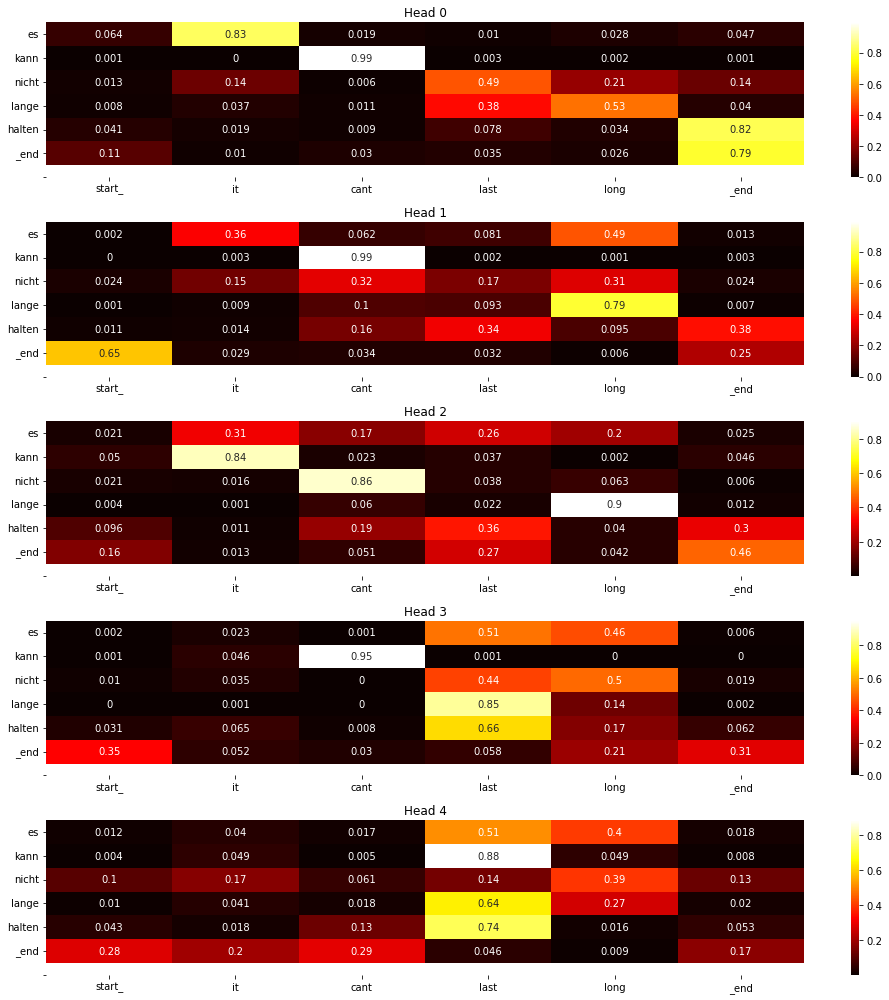

In [259]:
plot_attention_weights(pred_sentence, original_sentence, attention_weights)

In [260]:
sent_1 = 'Hello shall we go to school?'
pred_sentence, original_sentence, attention_weights = translate(sent_1, mappings, transformer, max_source_length, max_target_length)
pred_sentence, original_sentence

('schlage besser mit der schule _end ',
 'start_ hello shall we go to school _end')

decoder_layer4_block2_decenc_att


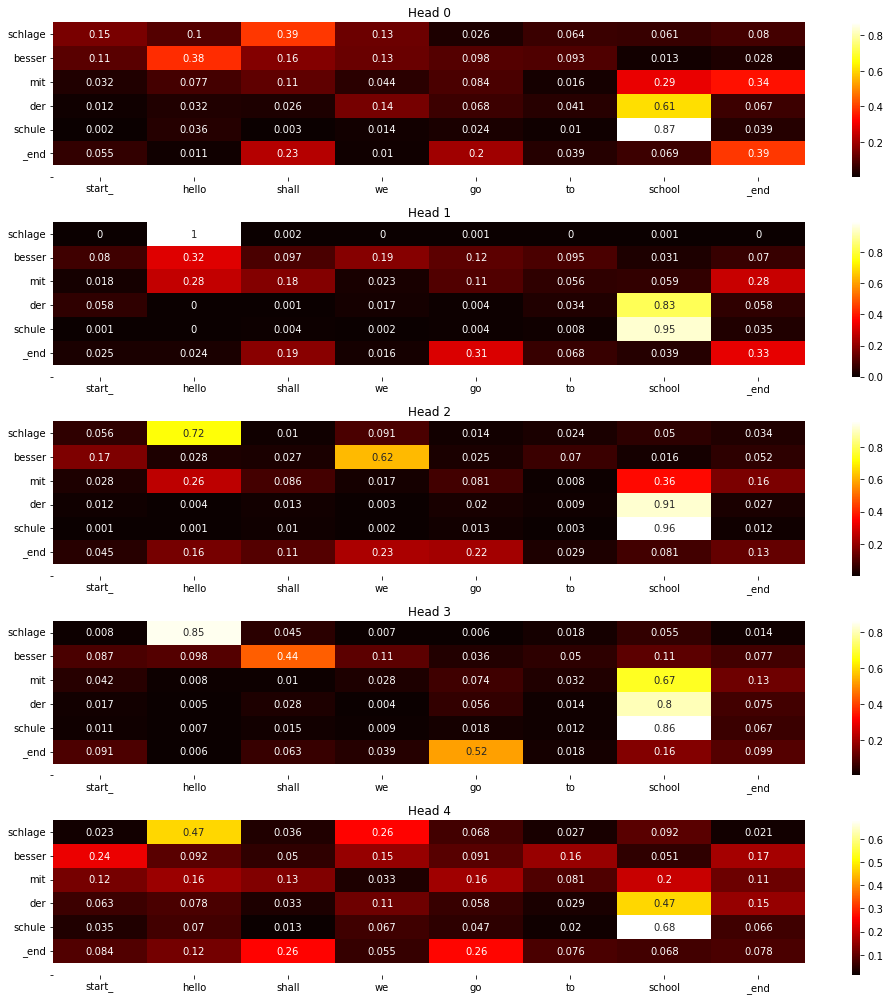

In [261]:
plot_attention_weights(pred_sentence, original_sentence, attention_weights)

In [250]:
file_path = 'saved_models/'
transformer.save_weights(file_path,save_format='tf')

# # Recreate the exact same model purely from the file
# new_model = keras.models.load_model('path_to_my_model')

In [251]:
new_transformer = Transformer(
        num_layers=num_layers,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    fully_connected_dim=fully_connected_dim,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    max_positional_encoding_input = max_positional_encoding_input,
    max_positional_encoding_target = max_positional_encoding_target
)

(1, 32, 128)
(1, 33, 128)


In [252]:
new_transformer.load_weights(file_path)

In [255]:
pred_sentence, original_sentence, attention_weights = random_translate_from_tensor(new_transformer, mappings)

Input: start_ i dont know the exact date _end
Predicted translation: ich weiss nicht die hauptstadt in den einzusammeln _end 
Actual translation: start_ ich kenne das genaue datum nicht _end 


decoder_layer4_block2_decenc_att


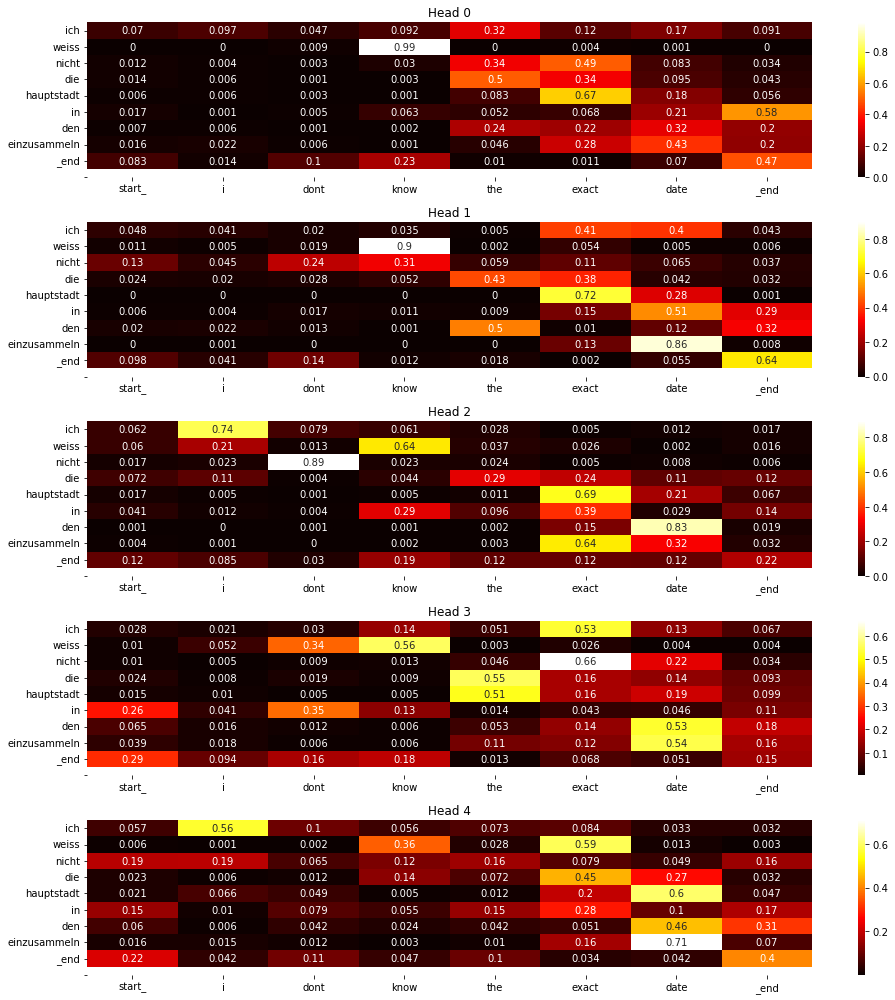

In [256]:
plot_attention_weights(pred_sentence, original_sentence, attention_weights)

In [151]:
def evaluate(source_input, transformer, max_source_length, max_target_length):
    """
    Arguments: 
    source_input -- (1, Tx) -- input sequence integers
    

    Returns:
    pred_sentence -- predicted sentence in words
    input_sentence -- input sentence in words
    """

    # Translate sequence of integers into words
    input_sentence = ''
    for i in source_input[0]:
        if i == 0:
            break
        input_sentence = input_sentence + source_index_word[i] + ' '

    source_input = tf.convert_to_tensor(source_input)

    # transformer call function: 
    # Arguments: inputs, training
        # inputs: 
            # input_sentence -- (batch_size, input_seq_len)
            # output_sentence -- (batch_size, target_seq_len)
    # Returns: 
    # final_output -- (batch_size, tar_seq_len, target_vocab_size)
    # attention_weights


    # Define tokens for "start_" and "_end"
    start = target_word_index['start_']
    end = target_word_index['_end']
    
    # Initialise output_array with "start_" token
    #output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    #output_array = output_array.write(0, start)
    output_array = tf.Variable([start], dtype = tf.int64 )
    output_array = tf.expand_dims(output_array, 0)

    pred_sentence = ''
    for t in range (max_target_length):
        #output = tf.transpose(output_array.stack())   # tf.expand_dims(tf.transpose(output_array.stack()), 0)
        output = output_array
        
        predictions, _ = transformer([source_input, output], training = False)       # (batch_size, tar_seq_len, target_vocab_size)
        
        predictions = predictions[:, -1:, :]                                      # select final time-step of predictions
        
        predicted_id = tf.argmax(predictions, axis=-1)
        
        predicted_id_int = int(predicted_id)
        
        pred_sentence += target_index_word[predicted_id_int] + ' '
        output_array = tf.concat([output_array, predicted_id], axis = 1)


        if predicted_id == end:
            break
    
        

    # get attention_weights for final time-step excluding the "_end" token
    _, attention_weights = transformer([source_input, output_array[:, :-1]], training = False)
    #output = tf.transpose(output_array.stack())          # output = (1, tokens)
    
    return pred_sentence, input_sentence, attention_weights
        


In [181]:
def predict_random_val_sentence(transformer):
    
    k = np.random.randint(len(source_train_tensor))
    random_input = source_train_tensor[k]
    random_output = target_train_tensor[k]
    random_input = np.expand_dims(random_input,0)           # random_input = (1, Tx)
        
    pred_sentence, input_sentence, attention_weights = evaluate(random_input, transformer, max_source_length, max_target_length)

    print(f'Input: {input_sentence}')
    print(f'Predicted translation: {pred_sentence}')
    
    true_translation = ''
    for i in random_output:
        if i == 0:
            break
        true_translation = true_translation + target_index_word[i] + ' '

    print(f'Actual translation: {true_translation}')
    return pred_sentence, input_sentence, attention_weights


In [153]:
def plot_attention_weights(pred_sentence, input_sentence, attention_weights):
    """
    attention_weights is a dictionary for each block of each decoder layer
    """
    
    pred_sentence, input_sentence = pred_sentence.split(' '), input_sentence.split(' ')
    pred_sentence, input_sentence = pred_sentence[:-1], input_sentence[:-1]             # remove empty string at final index
    len_input = len(input_sentence)

    # retrieve final key of dictionary – this corresponds to the final decoder layer, block 2 (decoder-encoder mha)
    final_block_decenc = list(attention_weights.keys())[-1]
    print(final_block_decenc)
    attention_block = attention_weights[final_block_decenc]     # attention_weights is a dictionary
                                                                # attention_block = (1, num_heads, len(pred_sentence), Tx)
    attention_block_squeezed = tf.squeeze(attention_block, 0)   # attention_block_squeezed = (num_heads, len(pred_sentence), Tx)
    num_heads = attention_block_squeezed.shape[0]

    fig, ax = plt.subplots(num_heads, 1, figsize = (14,14))
    
    for head in range (num_heads):
        temp_attn_block = attention_block_squeezed[head]
        temp_attn_block = np.around(temp_attn_block, 3)
        ax[head].set_title(f'Head {head}')
        sns.heatmap(temp_attn_block[:,:len_input], ax = ax[head], cmap = 'hot', annot = True, xticklabels = input_sentence, yticklabels = pred_sentence)
    
    plt.tight_layout()
    plt.show()

In [182]:
pred_sentence, input_sentence, attention_weights = predict_random_val_sentence(transformer)

Input: start_ the whale is a very large mammal which lives in the sea _end 
Predicted translation: die polizei ist ein sehr sehr wie die tuer hat _end 
Actual translation: start_ wale sind riesige saeugetiere die im meer leben _end 


decoder_layer4_block2_decenc_att


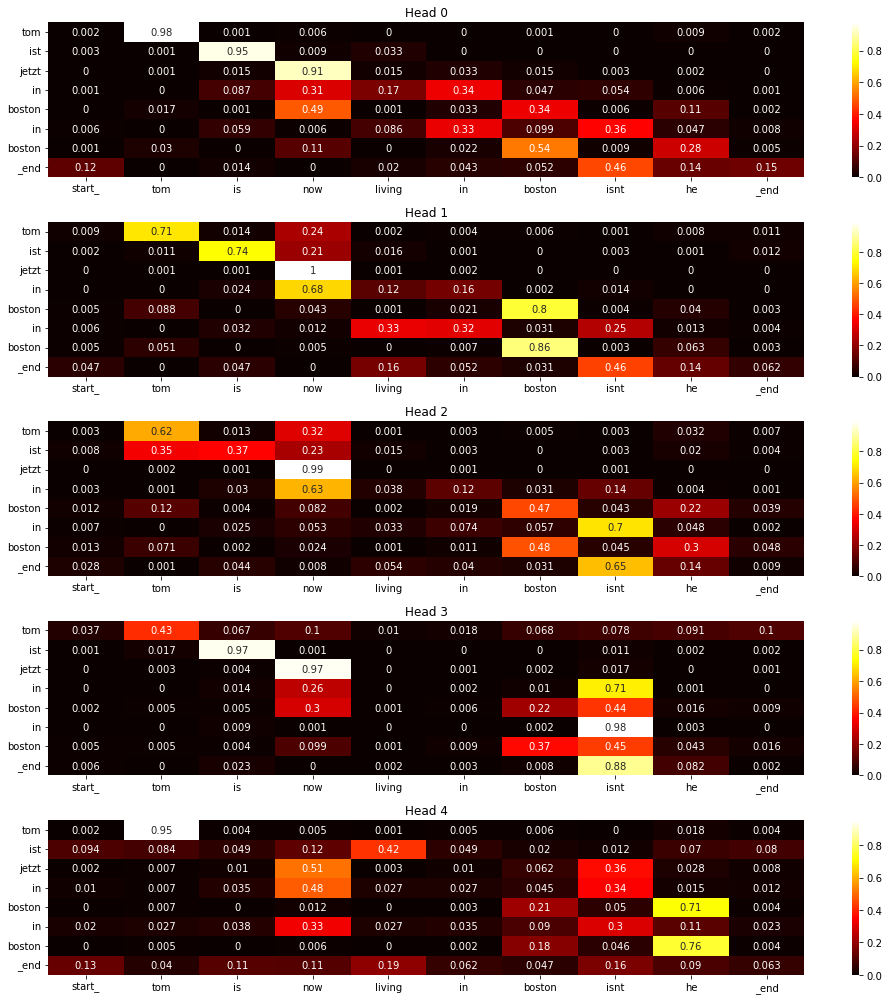

In [137]:
plot_attention_weights(pred_sentence, input_sentence, attention_weights)

In [474]:
file_path = 'saved_models/'
transformer.save_weights(file_path,save_format='tf')

# # Recreate the exact same model purely from the file
# new_model = keras.models.load_model('path_to_my_model')

In [475]:
new_transformer = Transformer(
        num_layers=num_layers,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    fully_connected_dim=fully_connected_dim,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    max_positional_encoding_input = max_positional_encoding_input,
    max_positional_encoding_target = max_positional_encoding_target
)


(1, 29, 128)
(1, 27, 128)


In [476]:
new_transformer.load_weights(file_path)

In [477]:
pred_sentence, input_sentence, attention_weights = predict_random_val_sentence(new_transformer)

Input: start_ you can always ask us for help _end 
Predicted translation: du kannst immer wenn wir immer helfen koennen _end 
Actual translation: start_ du kannst uns immer um hilfe beten _end 


decoder_layer4_block2_decenc_att


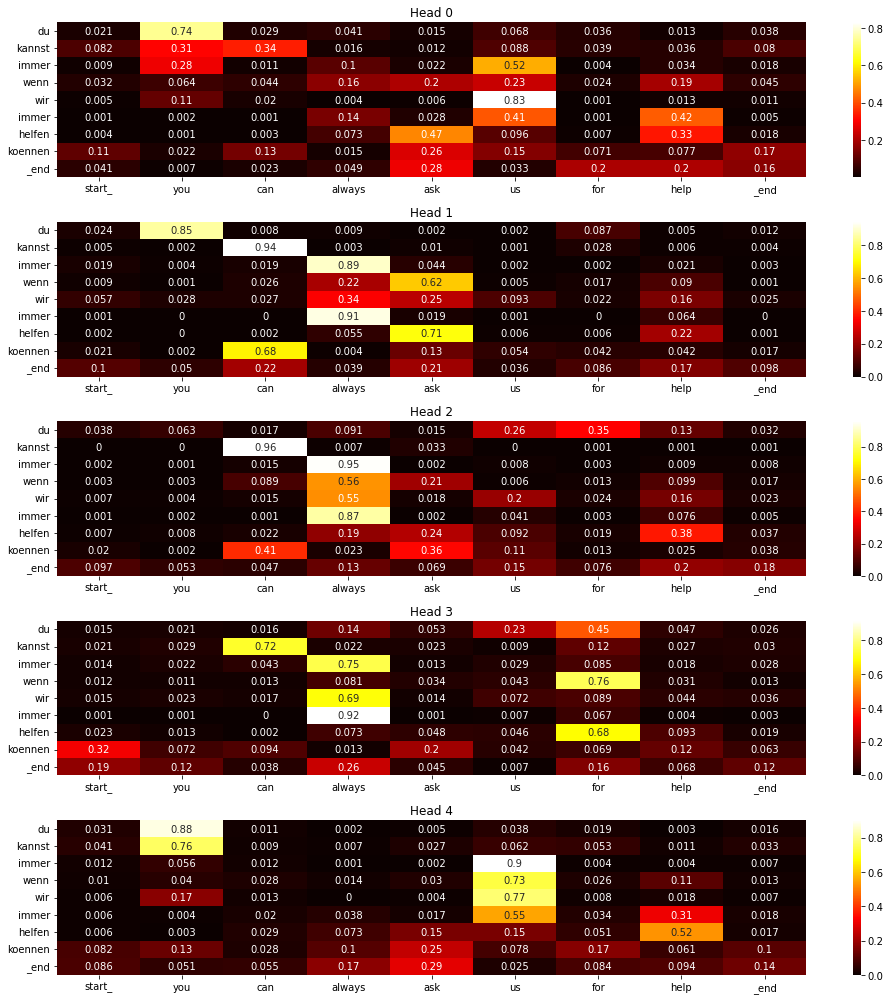

In [478]:
plot_attention_weights(pred_sentence, input_sentence, attention_weights)